# **Image Kernels**
## Explained Visually

An image kernel is a small matrix used to apply effects like the ones you might find in Photoshop or Gimp, such as blurring, sharpening, outlining or embossing. They're also used in machine learning for 'feature extraction', a technique for determining the most important portions of an image. In this context the process is referred to more generally as "convolution" (see: convolutional neural networks.)

To see how they work, let's start by inspecting a black and white image. The matrix on the left contains numbers, between 0 and 255, which each correspond to the brightness of one pixel in a picture of a face. The large, granulated picture has been blown up to make it easier to see; the last image is the "real" size.

**Convolution** is a simple mathematical operation which is fundamental to many common image processing operators. Convolution provides a way of *`multiplying together'* two arrays of numbers, generally of different sizes, but of the same dimensionality, to produce a third array of numbers of the same dimensionality.

Let's walk through applying the following 3x3 blur kernel to the image of a face from above.

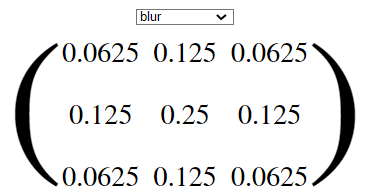

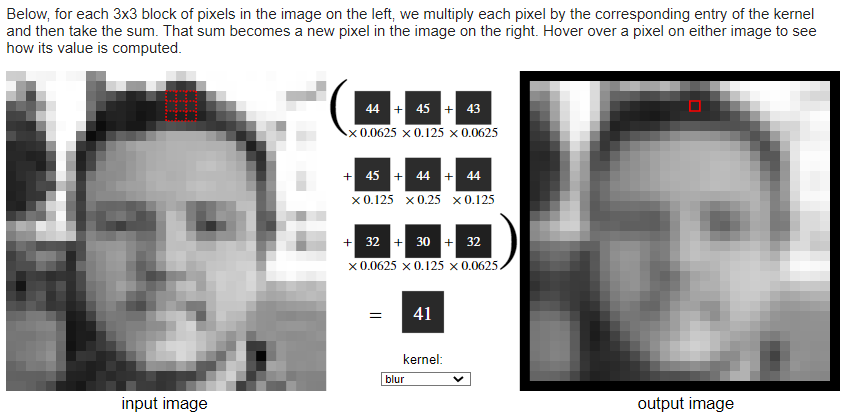

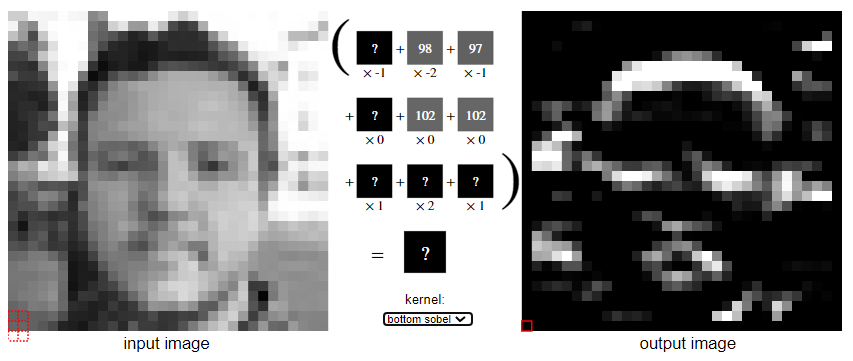

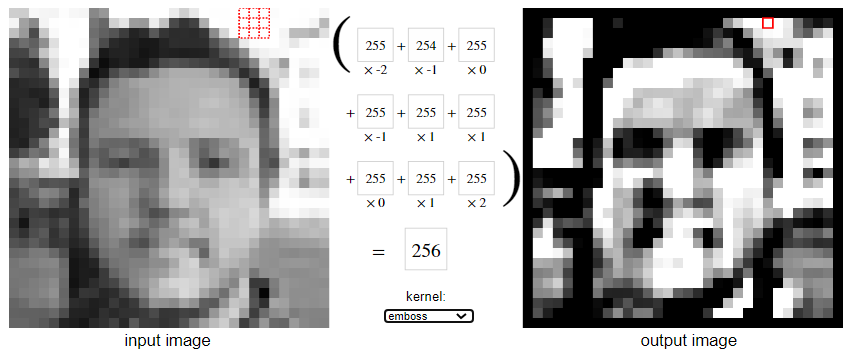

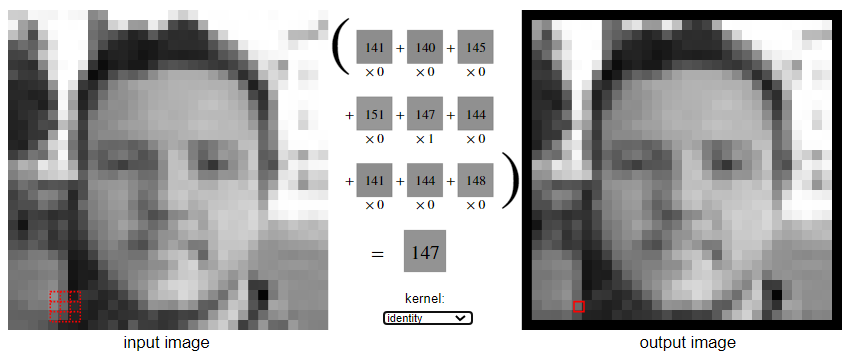

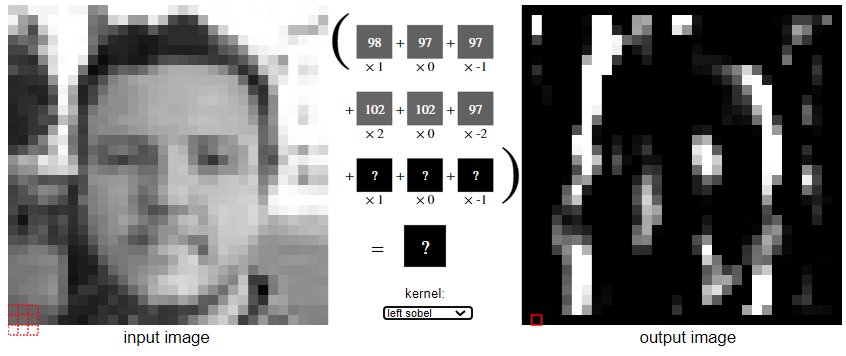

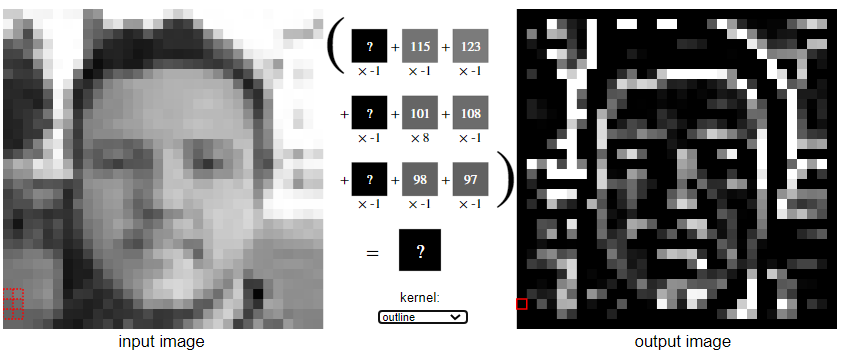

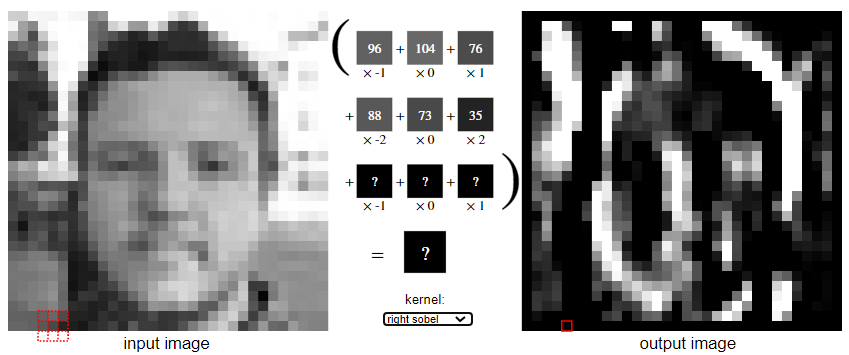

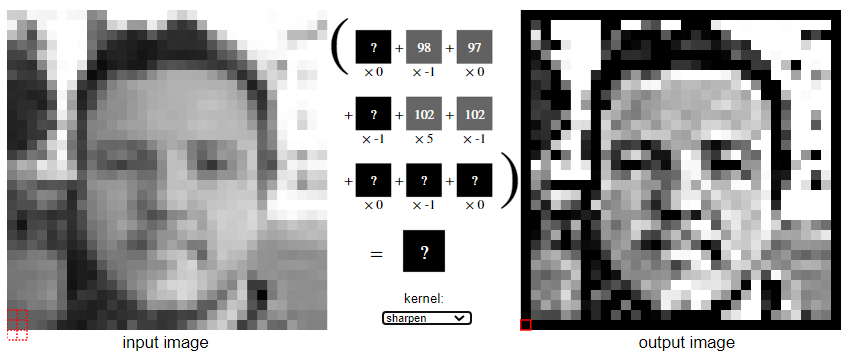

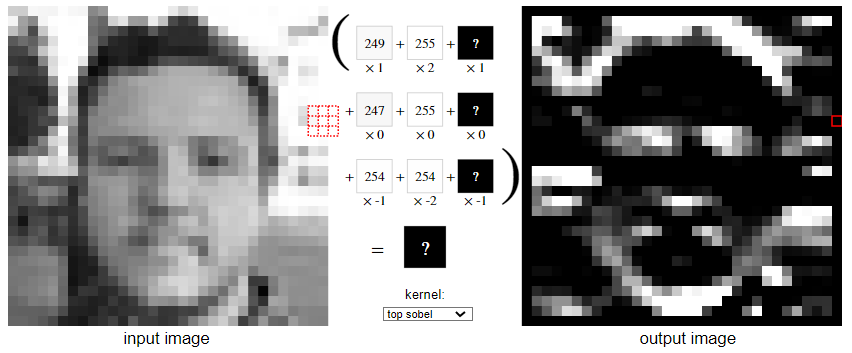

One subtlety of this process is what to do along the edges of the image. For example, the top left corner of the input image only has three neighbors. One way to fix this is to extend the edge values out by one in the original image while keeping our new image the same size. In this demo, we've instead ignored those values by making them black.

Here's a playground were you can select different kernel matrices and see how they effect the original image or build your own kernel. You can also upload your own image or use live video if your browser supports it.

# **Cascade Classifiers**
We’ll explore Cascade Classifiers at first.

## **I.1. Theory**
Cascade classifier, or namely cascade of boosted classifiers working with haar-like features, is a special case of ensemble learning, called boosting. It typically relies on Adaboost classifiers (and other models such as Real Adaboost, Gentle Adaboost or Logitboost).
Cascade classifiers are trained on a few hundred sample images of image that contain the object we want to detect, and other images that do not contain those images.

**How can we detect if a face is there or not ?**

There is an algorithm, called Viola–Jones object detection framework, that includes all the steps required for live face detection :

1. Haar Feature Selection

2. features derived from Haar wavelets

3. Create integral image

4. Adaboost Training

5. Cascading Classifiers

### **A. Haar Feature Selection**
There are some common features that we find on most common human faces :

* a dark eye region compared to upper-cheeks
* a bright nose bridge region compared to the eyes
* some specific location of eyes, mouth, nose…

The characteristics are called Haar Features. The feature extraction process will look like this :

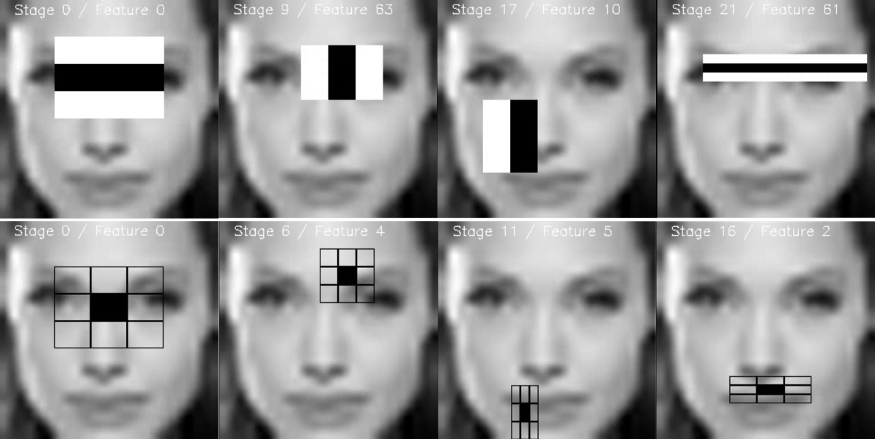

In this example, the first feature measures the difference in intensity between the region of the eyes and a region across the upper cheeks. The feature value is simply computed by summing the pixels in the black area and subtracting the pixels in the white area.

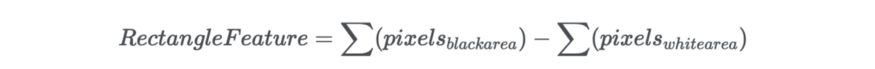



Then, we apply this rectangle as a convolutional kernel, over our whole image. In order to be exhaustive, we should apply all possible dimensions and positions of each kernel. A simple 24*24 images would typically result in over 160’000 features, each made of a sum/subtraction of pixels values. It would computationally be impossible for live face detection. So, how do we speed up this process ?

* once the good region has been identified by a rectangle, it is useless to run the window over a completely different region of the image. This can be achieved by Adaboost.

* compute the rectangle features using the integral image principle, which is way faster. We’ll cover this in the next section.

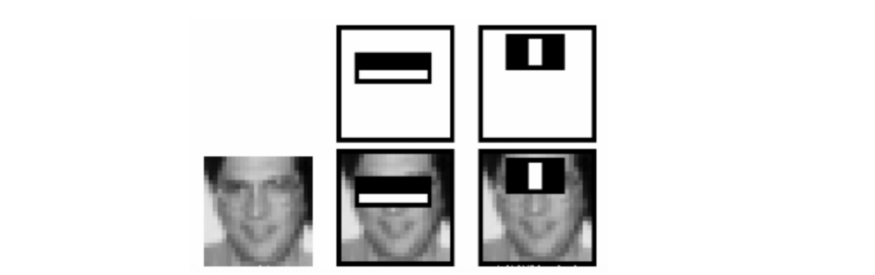

There are several types of rectangles that can be applied for Haar Features extraction. According to the original paper :
* the two-rectangle feature is the difference between the sum of the pixels within two rectangular regions, used mainly for detecting edges (a,b)

* the three-rectangle feature computes the sum within two outside rectangles subtracted from the sum in a center rectangle, used mainly for detecting lines (c,d)

* the four-rectangle feature computes the difference between diagonal pairs of rectangle (e)

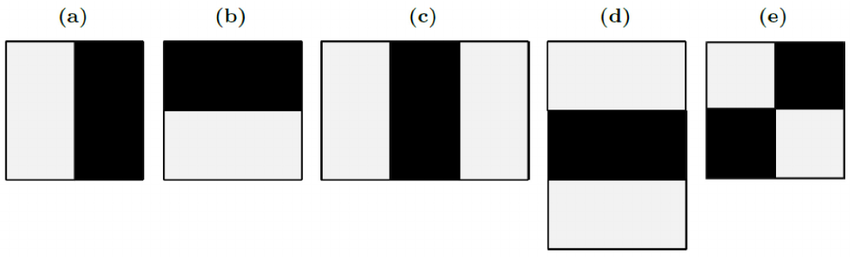

Now that the features have been selected, we apply them on the set of training images using Adaboost classification, that combines a set of weak classifiers to create an accurate ensemble model. With 200 features (instead of 160’000 initially), an accuracy of 95% is achieved. The authors of the paper have selected 6’000 features.

### **b. The integral image**
Computing the rectangle features in a convolutional kernel style can be long, very long. For this reason, the authors, Viola and Jones, proposed an intermediate representation for the image : the integral image. The role of the integral image is to allow any rectangular sum to be computed simply, using only four values. We’ll see how it works !
Suppose we want to determine the rectangle features at a given pixel with coordinates (x,y). Then, the integral image of the pixel in the sum of the pixels above and to the left of the given pixel.

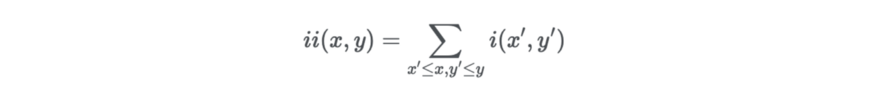

where ii(x,y) is the integral image and i(x,y) is the original image.
When you compute the whole integral image, there is a form a recurrence which requires only one pass over the original image. Indeed, we can define the following pair of recurrences :

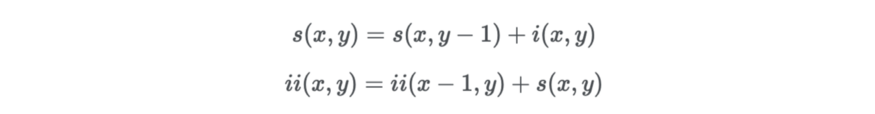

where s(x,y) is the cumulative row sum and and s(x−1)=0, ii(−1,y)=0.


**How can that be useful ?** Well, consider a region D for which we would like to estimate the sum of the pixels. We have defined 3 other regions : A, B and C.

* The value of the integral image at point 1 is the sum of the pixels in rectangle A.
* The value at point 2 is A + B
* The value at point 3 is A + C
* The value at point 4 is A + B + C + D.
* Therefore, the sum of pixels in region D can simply be computed as : 4+1−(2+3).

And over a single pass, we have computed the value inside a rectangle using only 4 array references.

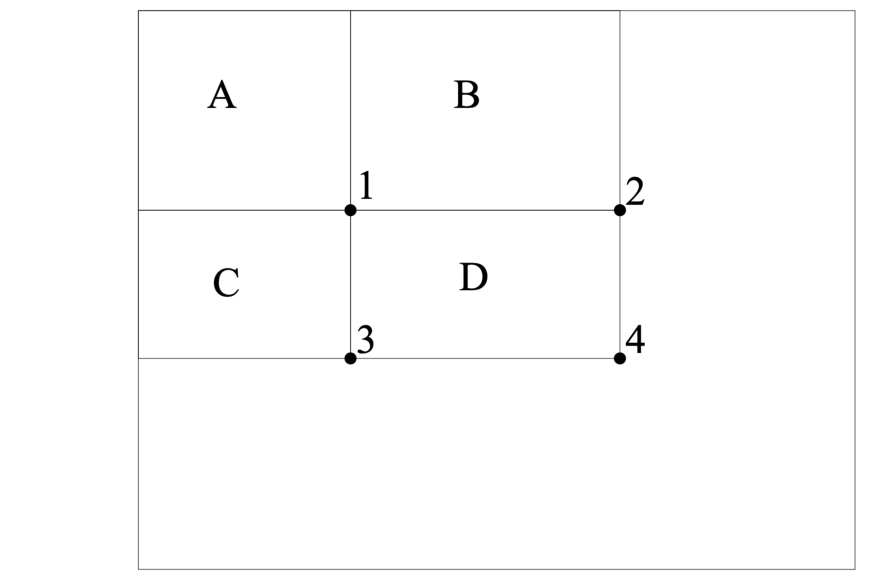

One should simply be aware that rectangles are quite simple features in practice, but sufficient for face detection. Steerable filters tend to be more flexible when it comes to complex problems.

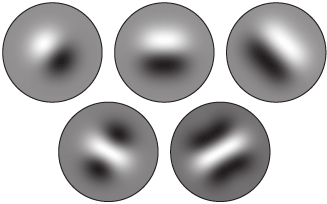



### **c. Learning the classification function with Adaboost**

Given a set of labeled training images (positive or negative), Adaboost is used to :

* select a small set of features

* and train the classifier

Since most features among the 160’000 are supposed to be quite irrelevant, the weak learning algorithm around which we build a boosting model is designed to select the single rectangle feature which splits best negative and positive examples.

**d. Cascading Classifier**

Although the process described above is quite efficient, a major issue remains. In an image, most of the image is a non-face region. Giving equal importance to each region of the image makes no sense, since we should mainly focus on the regions that are most likely to contain a picture. Viola and Jones achieved an increased detection rate while reducing computation time using Cascading Classifiers.

The key idea is to reject sub-windows that do not contain faces while identifying regions that do. Since the task is to identify properly the face, we want to minimize the false negative rate, i.e the sub-windows that contain a face and have not been identified as such.
A series of classifiers are applied to every sub-window. These classifiers are simple decision trees :

* if the first classifier is positive, we move on to the second.

* if the second classifier is positive, we move on to the third.

…
Any negative result at some point leads to a rejection of the sub-window as potentially containing a face. The initial classifier eliminates most negative examples at a low computational cost, and the following classifiers eliminate additional negative examples but require more computational effort.

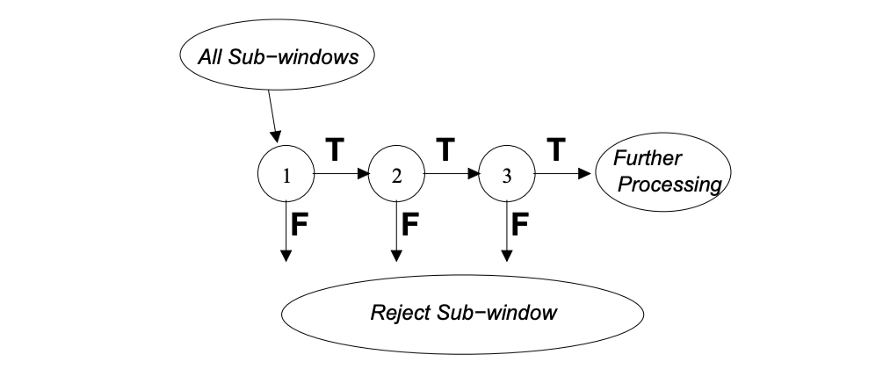

The classifiers are trained using Adaboost and adjusting the threshold to minimize the false rate. When training such model, the variables are the following :

* the number of classifier stages
* the number of features in each stage
* the threshold of each stage

Luckily in OpenCV, this whole model is already pre-trained for face detection.

**Why do we use grayscale images in image processing?**

A grayscale (or graylevel) image is simply one in which the only colors are shades of gray. The reason for differentiating such images from any other sort of color image is that less information needs to be provided for each pixel.

**Why do computers typically use grayscale for video analytics?**

Because it is a one layer image from 0-255 whereas the RGB have three different layer image. So that is a reason we prefer grey scale image instead of RGB.

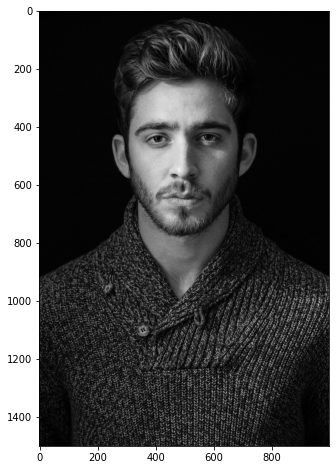

In [ ]:
# Load the image
import cv2 as cv
import matplotlib.pylab as plt
gray = cv.imread('/content/drive/MyDrive/PIX DYNAMICS/TRAINING/COLAB/SAMPLE DATA/OPEN CV/FACE/photo-1506794778202-cad84cf45f1d.jpg', 0)
plt.figure(figsize=(12,8))
plt.imshow(gray, cmap='gray')
plt.show()

Then, we detect the face and we add a rectangle around it :

In [ ]:
cascPath = "/usr/local/lib/python3.7/site-packages/cv2/data/haarcascade_frontalface_default.xml"
eyePath = "/usr/local/lib/python3.7/site-packages/cv2/data/haarcascade_eye.xml"
smilePath = "/usr/local/lib/python3.7/site-packages/cv2/data/haarcascade_smile.xml"

In [ ]:
faceCascade = cv.CascadeClassifier(cascPath)
eyeCascade = cv.CascadeClassifier(eyePath)
smileCascade = cv.CascadeClassifier(smilePath)

In [ ]:
faceCascade = cv.CascadeClassifier(cv.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.3,
        minNeighbors=3,
        minSize=(30, 30)
) 

# For each face
for (x, y, w, h) in faces: 
    # Draw rectangle around the face
    cv.rectangle(gray, (x, y), (x+w, y+h), (255, 255, 255), 3)

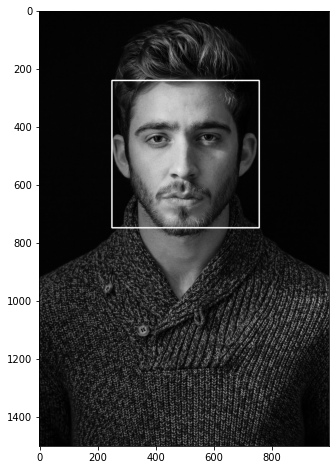

In [ ]:
plt.figure(figsize=(12,8))
plt.imshow(gray, cmap='gray')
plt.show()

## **Real time face detection**

Let’s move on to the Python implementation of the live facial detection. The first step is to launch the camera, and capture the video. Then, we’ll transform the image to a gray scale image. This is used to reduce the dimension of the input image. Indeed, instead of 3 points per pixel describing Red, Green, Blue, we apply a simple linear transformation :

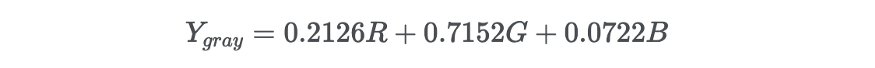

This is implemented by default in OpenCV.

## **Face detection using Cascade Classifier using OpenCV-Python**

One of the popular algorithms for facial detection is “haarcascade”. It is computationally less expensive, a fast algorithm, and gives high accuracy.

https://drive.google.com/file/d/1PPO2MCttsmSqyB-vKh5C7SumwFKuhgyj/view?usp=sharing

### **It works in four stages:**

* **Haar-feature selection:** A Haar-like feature consists of dark regions and light regions. It produces a single value by taking the difference of the sum of the intensities of the dark regions and the sum of the intensities of light regions. It is done to extract useful elements necessary for identifying an object. The features proposed by viola and jones are:


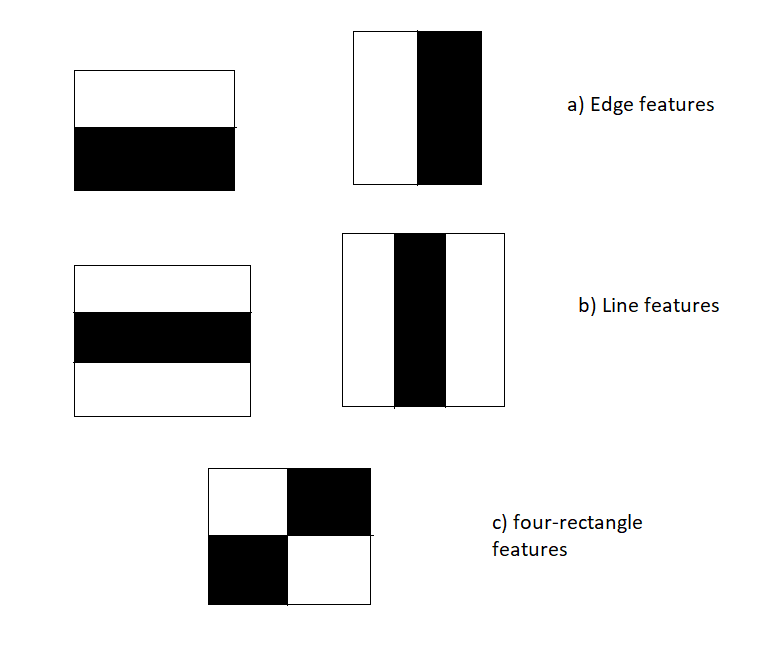


**Creation of Integral Images:** 

A given pixel in the integral image is the sum of all the pixels on the left and all the pixels above it. Since the process of extracting Haar-like features involves calculating the difference of dark and light rectangular regions, the introduction of Integral Images reduces the time needed to complete this task significantly.



**AdaBoost Training:** 

This algorithm selects the best features from all features. It combines multiple “weak classifiers” (best features) into one “strong classifier”. The generated “strong classifier” is basically the linear combination of all “weak classifiers”.


**Cascade Classifier:**

It is a method for combining increasingly more complex classifiers like AdaBoost in a cascade which allows negative input (non-face) to be quickly discarded while spending more computation on promising or positive face-like regions. It significantly reduces the computation time and makes the process more efficient.


OpenCV comes with lots of pre-trained classifiers. Those XML files can be loaded by cascadeClassifier method of the cv2 module. Here we are going to use haarcascade_frontalface_default.xml for detecting faces.

## **Stepwise Implementation:**

**Step 1: Loading the image**

**Step 2: Converting the image to grayscale**

Initially, the image is a three-layer image (i.e., RGB), So It is converted to a one-layer image (i.e., grayscale). 

**Step 3: Loading the required haar-cascade XML classifier file**

CascadeClassifier method in cv2 module supports the loading of haar-cascade XML files. Here, we need ***“haarcascade_frontalface_default.xml”*** for face detection.

**Step 4: Applying the face detection method on the grayscale image**

This is done using the cv2::CascadeClassifier::detectMultiScale method, which returns boundary rectangles for the detected faces (i.e., x, y, w, h). It takes two parameters namely, scaleFactor and minNeighbors. ScaleFactor determines the factor of increase in window size which initially starts at size “minSize”, and after testing all windows of that size, the window is scaled up by the “scaleFactor”, and the window size goes up to “maxSize”. If the “scaleFactor” is large, (e.g., 2.0), there will be fewer steps, so detection will be faster, but we may miss objects whose size is between two tested scales. (default scale factor is 1.3). Higher the values of the “minNeighbors”, less will be the number of false positives, and less error will be in terms of false detection of faces. However, there is a chance of missing some unclear face traces as well.

**Step 5: Iterating through rectangles of detected faces**

Rectangles are drawn around the detected faces by the rectangle method of the cv2 module by iterating over all detected faces. 